Apple Stock Data EDA Prediction

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.switch_backend('Agg')

%matplotlib inline

import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Table of Contents
• Data Loading and Preprocessing
• Exploratory Data Analysis
• Prediction with Linear Regression
• Summary and Future Work

# Data Loading and Preprocessing
In this section we load several files from the Apple Stock dataset and standardize their column
names and date formats. An error that some users encountered was due to mixing timezone-aware
and timezone-naive datetime objects when sorting by date. To solve this, we ensure that all
datetime objects are made timezone-naive.

In [4]:
# List of file paths
file_paths = [
    '/Users/carlovilloresi/Documents/My Projects/Market Analysis/JupyterProject/kaggle/input/AAPL_1980-12-13_2025-01-31.csv',
    '/Users/carlovilloresi/Documents/My Projects/Market Analysis/JupyterProject/kaggle/input/AAPL_1980-12-03_2025-02-07.csv',
    '/Users/carlovilloresi/Documents/My Projects/Market Analysis/JupyterProject/kaggle/input/AAPL_1980-12-03_2025-02-24.csv',
    '/Users/carlovilloresi/Documents/My Projects/Market Analysis/JupyterProject/kaggle/input/AAPL_1980-12-13_2025-01-20.csv',
    '/Users/carlovilloresi/Documents/My Projects/Market Analysis/JupyterProject/kaggle/input/AAPL_1980-12-03_2025-02-18.csv'
]

def load_and_standardize(file_path):
    """
    Load a CSV file and standardize column names.
    This function ensures that date columns are converted to datetime and any timezone information is removed.
    """
    # Read the CSV file with specified encoding and delimiter
    df = pd.read_csv(file_path, encoding='ascii', delimiter=',')

    # Standardize column names: Strip whitespace and Title-case them
    df.columns = [col.strip().title() for col in df.columns]

    # Explicitly rename columns if needed
    rename_map = {
        'Adj_Close': 'Adj Close',
        'Open': 'Open',
        'High': 'High',
        'Low': 'Low',
        'Close': 'Close',
        'Volume': 'Volume'
    }
    df.rename(columns=rename_map, inplace=True)

    # Convert 'Date' column to datetime and remove any timezone information
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

    # Remove timezone info if present by applying a lambda function
    df['Date'] = df['Date'].apply(lambda dt: dt.tz_localize(None) if (hasattr(dt, 'tzinfo') and dt.tzinfo is not None) else dt)

    return df

# Load and concatenate all dataframes
df_list = [load_and_standardize(fp) for fp in file_paths]
df = pd.concat(df_list, ignore_index=True)

# Sort the dataframe by date. Since all dates are now tz-naive, no comparison errors occur
df.sort_values('Date', inplace=True)

# Reset index after sorting
df.reset_index(drop=True, inplace=True)

print('Data loaded and merged. Shape:', df.shape)
print('Columns:', df.columns.tolist())

Data loaded and merged. Shape: (55641, 7)
Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


# Exploratory Data Analysis
In this section we are curious about the dataset's structure and relationships. We plot a variety
of visuals to highlight trends, distributions, and correlations among the numerical columns.

In [12]:
# Display the first few rows and a summary of the dataframe
print(df.head())
print(df.info())

        Date      Open      High       Low     Close  Adj Close     Volume
0 1980-12-12  0.128348  0.128906  0.128348  0.128348   0.098726  469033600
1 1980-12-12  0.128348  0.128906  0.128348  0.128348   0.098726  469033600
2 1980-12-12  0.128348  0.128906  0.128348  0.128348   0.098834  469033600
3 1980-12-15  0.122210  0.122210  0.121652  0.121652   0.093678  175884800
4 1980-12-15  0.122210  0.122210  0.121652  0.121652   0.093575  175884800
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55641 entries, 0 to 55640
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       55641 non-null  datetime64[ns]
 1   Open       55641 non-null  float64       
 2   High       55641 non-null  float64       
 3   Low        55641 non-null  float64       
 4   Close      55641 non-null  float64       
 5   Adj Close  55641 non-null  float64       
 6   Volume     55641 non-null  int64         
dtypes: datetime64[

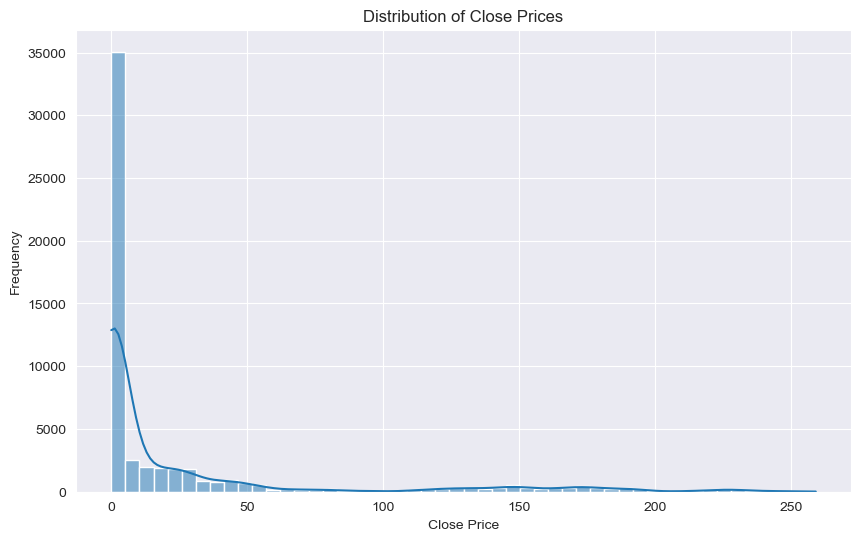

In [13]:
# Histogram of the 'Close' prices to see the distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Close'], bins=50, kde=True)
plt.title('Distribution of Close Prices')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.show()

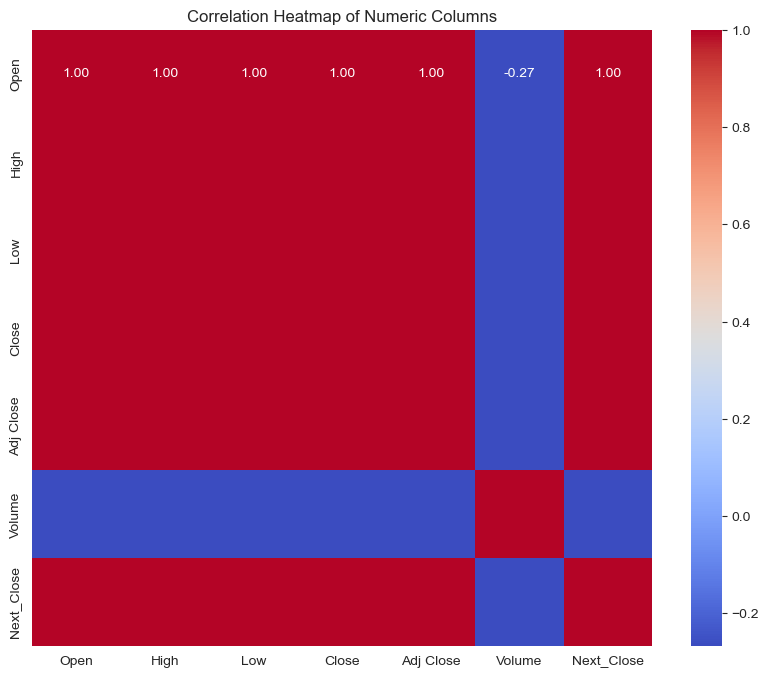

In [18]:
# Correlation heatmap for numeric columns (using only numeric data)
numeric_df = df.select_dtypes(include=[np.number])

if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(10, 8))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Numeric Columns')
    plt.show()
else:
    print('Not enough numeric columns for a correlation heatmap.')

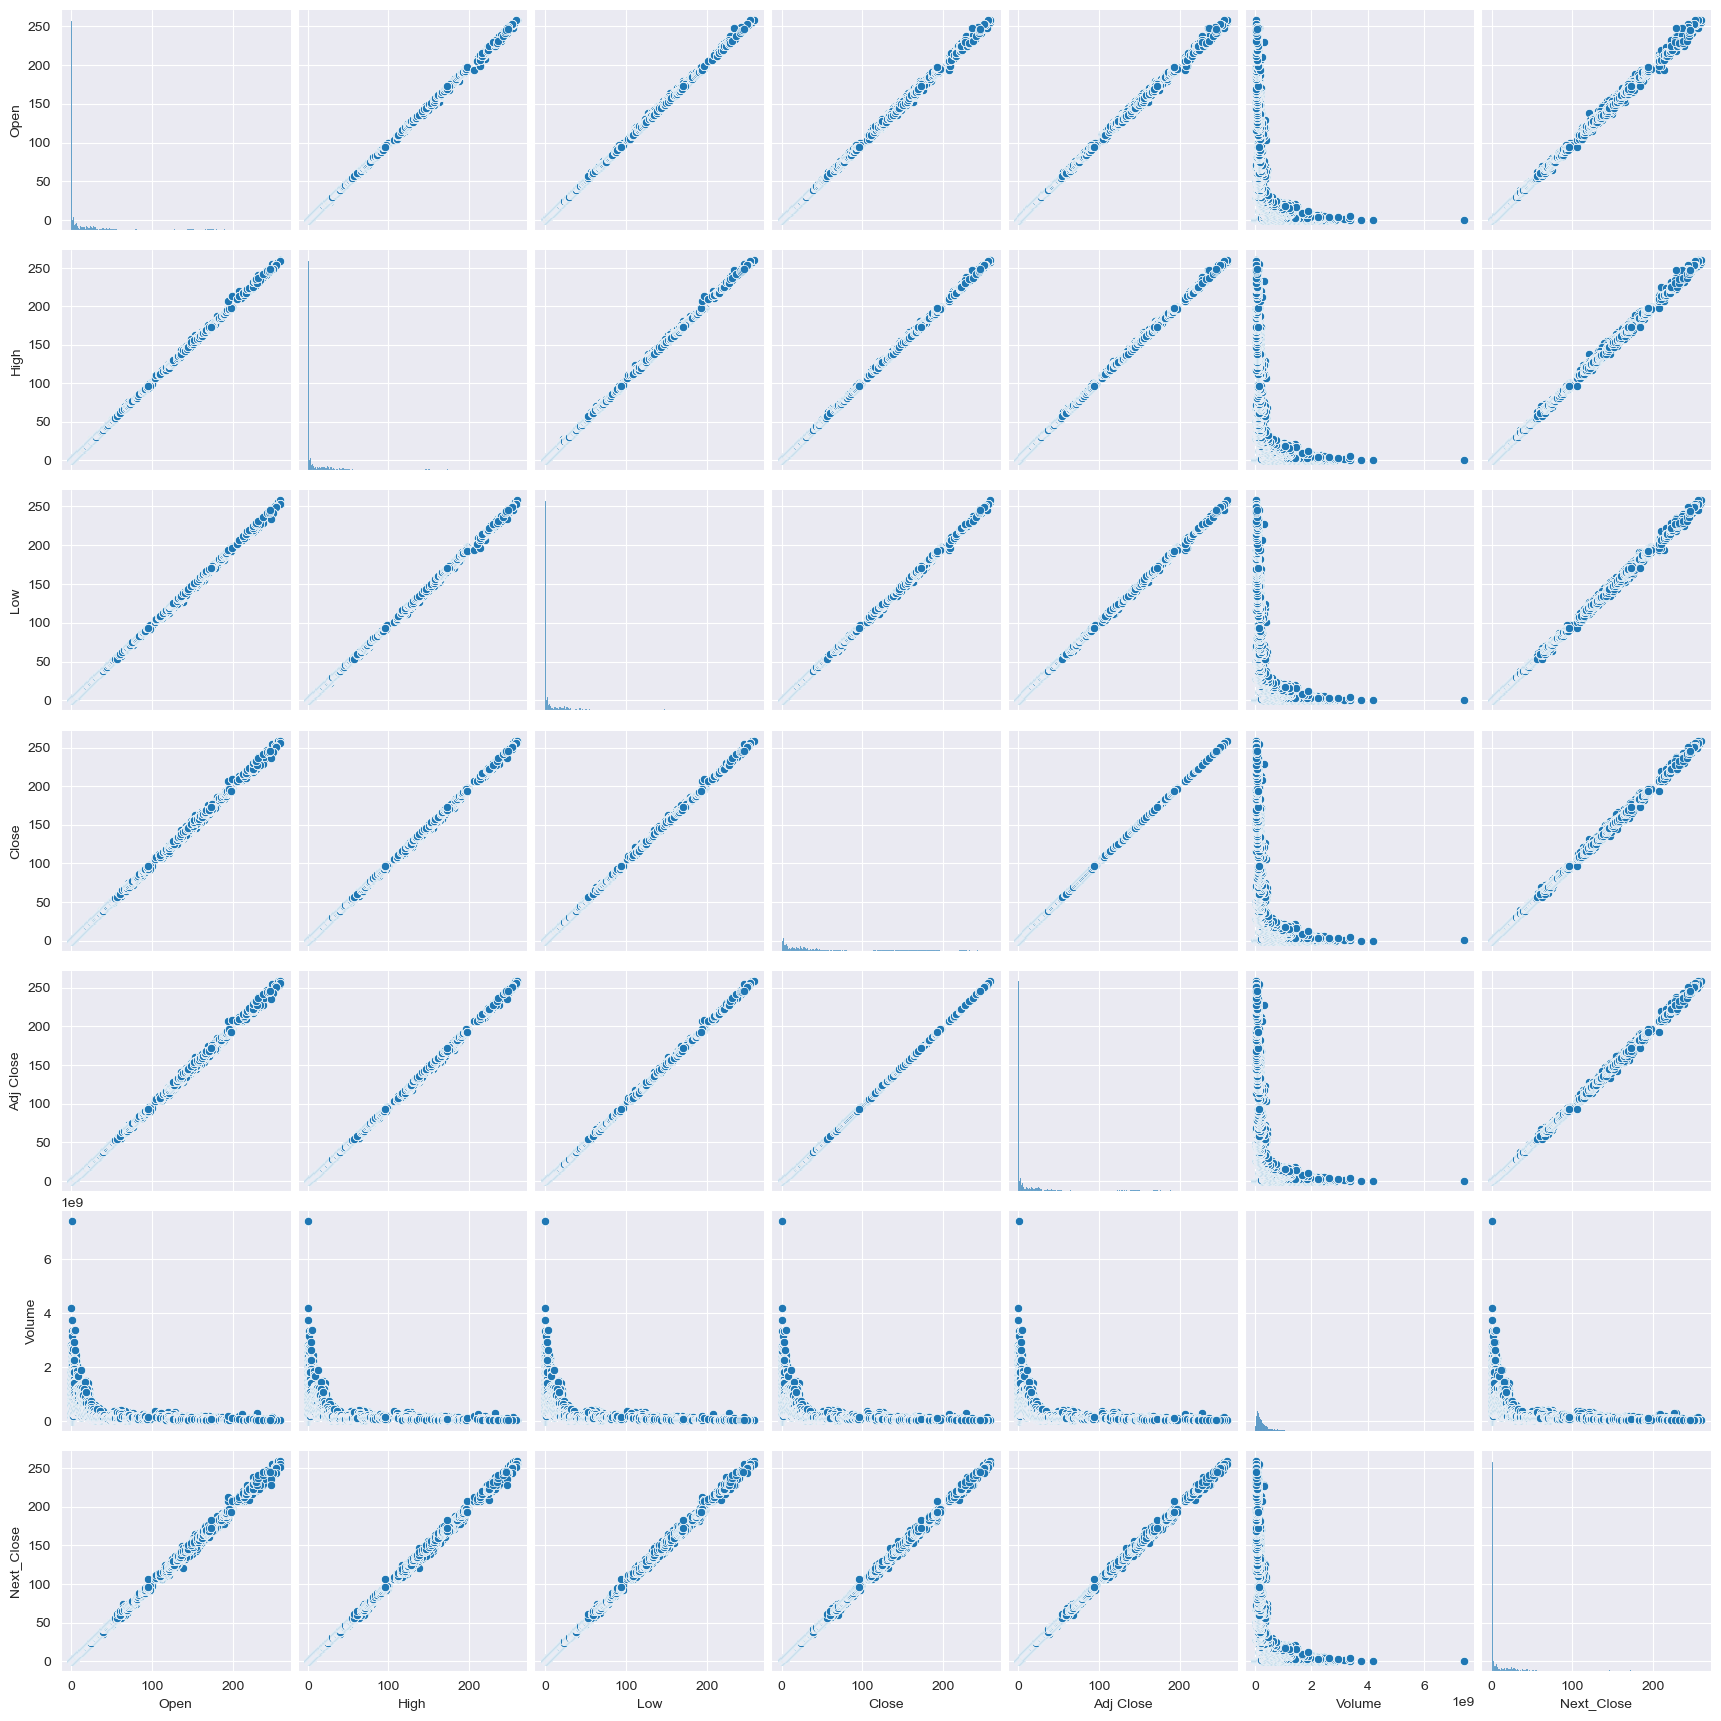

In [19]:
# Pair plot to visualize potential relationships between numeric features
sns.pairplot(numeric_df)
plt.show()

# Prediction with Linear Regression
Now we attempt something a little predictive. Although forecasting stock prices is notoriously difficult, we set up a simple regression model to predict the next day's closing price using today's market data.

Before modeling, we create a new column 'Next_Close' as a shifted version of the 'Close' price. We then split the data chronologically into a training and testing set (80% for training, 20% for testing) to maintain the temporal order of stock data.

In [15]:
# Create a new column 'Next_Close' which is the next day's closing price
df['Next_Close'] = df['Close'].shift(-1)

# Remove the last row as it will have NaN for 'Next_Close'
df_model = df.dropna(subset=['Next_Close']).copy()

# Define the features and target variable
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
target = 'Next_Close'

# Split the data into training and testing sets in a time-series aware manner
split_index = int(len(df_model) * 0.8)
train = df_model.iloc[:split_index]
test = df_model.iloc[split_index:]

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

# Initialize and train the Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict on the test set
y_pred = lr.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print('Linear Regression Model Performance:')
print('RMSE:', rmse)
print('R^2 Score:', r2)

Linear Regression Model Performance:
RMSE: 0.9572533639769136
R^2 Score: 0.9997846391336922


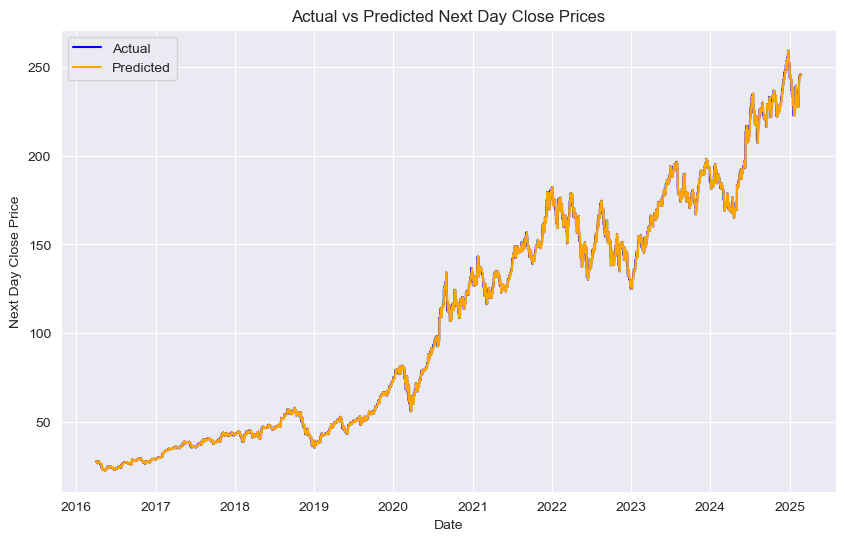

In [16]:
# Plotting Actual vs Predicted Next Day Close prices
plt.figure(figsize=(10, 6))
plt.plot(test['Date'], y_test, label='Actual', color='blue')
plt.plot(test['Date'], y_pred, label='Predicted', color='orange')
plt.xlabel('Date')
plt.ylabel('Next Day Close Price')
plt.title('Actual vs Predicted Next Day Close Prices')
plt.legend()
plt.show()